## LightGBM and ARIMA
This notebook gives an example of how to train a LightGBM model to generate point forecasts for product sales in retail. We will train a LightGBM model based on the Orange Juice dataset.

LightGBM is a gradient boosting framework that uses tree-based learning algorithms. Gradient boosting is an ensemble technique in which models are added to the ensemble sequentially and at each iteration a new model is trained with respect to the error of the whole ensemble learned so far. More detailed information about gradient boosting can be found in this tutorial paper. Using this technique, LightGBM achieves great accuracy in many applications. Apart from this, it is designed to be distributed and efficient with the following advantages:

Fast training speed and high efficiency, Low memory usage, Support of parallel and GPU learning, Capable of handling large-scale data.

ARIMA stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
import warnings
from pylab import rcParams
plt.style.use('fivethirtyeight')
sns.set()

rcParams['figure.figsize'] = 18, 8

warnings.filterwarnings("ignore")

In C:\Users\hermann.o.soh.tom\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\hermann.o.soh.tom\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\hermann.o.soh.tom\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\hermann.o.soh.tom\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotli

## Data Exploration
### Reading the train data ang merge it with the master data provided


In [2]:
sales_df = pd.read_csv(r'C:\Users\hermann.o.soh.tom\Downloads\sales_train.csv', parse_dates=['date'])
items_df = pd.read_csv(r'C:\Users\hermann.o.soh.tom\Downloads\items.csv')
shops_df = pd.read_csv(r'C:\Users\hermann.o.soh.tom\Downloads\shops.csv')
categories_df = pd.read_csv(r'C:\Users\hermann.o.soh.tom\Downloads\item_categories.csv')

merged_df_1 = pd.merge(sales_df, items_df, on='item_id', how='left')
merge_df = pd.merge(merged_df_1, categories_df, on='item_category_id', how='left')

raw_df = merge_df.query('item_category_id in (55, 56, 57, 58)')
raw_df['date'].min(), raw_df['date'].max()
raw_df.isna().sum()
raw_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
1,2013-03-01,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
6,2013-02-01,0,25,2565,549.00,1.0,DEEP PURPLE Stormbringer (фирм.),56,Музыка - CD фирменного производства


In [3]:
#set a for the analysis and a set of category
cleaned_df = raw_df.query('shop_id in (4, 1)')
cleaned_df["date"] = pd.to_datetime(cleaned_df['date'], format='%d.%m.%Y')
cleaned_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
30083,2013-05-01,0,4,6005,299.0,1.0,RAMMSTEIN Made In Germany,55,Музыка - CD локального производства
30084,2013-12-01,0,4,6007,299.0,1.0,RAMMSTEIN Mutter,55,Музыка - CD локального производства
30094,2013-01-30,0,4,6021,399.0,1.0,REA CHRIS Still So Far To Go The Best Of Chr...,55,Музыка - CD локального производства
30108,2013-01-20,0,4,5552,299.0,1.0,PRODIGY The Fat Of The Land 2CD,55,Музыка - CD локального производства
30159,2013-11-01,0,4,6045,299.0,1.0,RIHANNA Unapologetic,55,Музыка - CD локального производства


In [ ]:
#implementare un dataframe con 4 colonne contenente le vendite di item al giorno per shop
sales_df

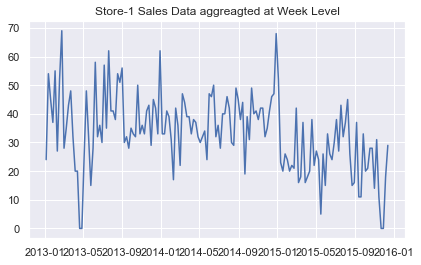

In [4]:
store1_4 = cleaned_df.loc[cleaned_df['shop_id']==4].groupby(['date'])['item_cnt_day'].sum()
store1_4.index = pd.to_datetime(store1_4.index)
store1_agg_weekly = store1_4.resample('W').sum()
store1_agg_ts = store1_4.resample('W').sum()
sns.lineplot(
    data=store1_agg_weekly,
)
plt.title("Store-1 Sales Data aggreagted at Week Level")
plt.show()
store1_agg_weekly.head()
store1_agg_weekly['date'] = store1_agg_weekly.index
#visualizzare anche la ditribuzione gaussiana

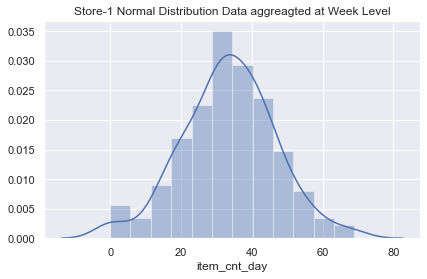

In [5]:
store1_agg_weekly = pd.DataFrame(store1_agg_weekly)
store1_agg_weekly = store1_agg_weekly.reset_index()
sns.distplot(
    store1_agg_weekly['item_cnt_day'][:154]
)
plt.title("Store-1 Normal Distribution Data aggreagted at Week Level")
plt.show()

In [7]:
#ts = pd.DataFrame(store1_agg_weekly[:len(store1_agg_weekly)-1])
#ts['date'] = pd.to_datetime(ts.index)
#ts.loc[ts.index <= "2015-06-01"].copy()

### chcking missing values in the dataset

In [ ]:
#check missing values here

## Data Preparation 
train test the dataset

In [8]:
#define a function to split the data to train the model, split on a time basis??? senza percentile 
ts = pd.DataFrame(store1_agg_weekly[:len(store1_agg_weekly)-1])
ts.index = ts['date']
def split_train_test(ts, test):
    split_date = test
    ts_train = ts.loc[ts.index <= split_date].copy()
    ts_test = ts.loc[ts.index > split_date].copy()
    
    ts_train = pd.DataFrame(ts_train)
    ts_test = pd.DataFrame(ts_test)
    return ts_train, ts_test

ts_train, ts_test = split_train_test(ts, test="2015-06-01")
# reset the index to be use by the train_test_split of sklearn
ts_train['sales'] = ts_train['item_cnt_day']
ts_test['sales'] = ts_test['item_cnt_day']

## result dataframe
this dataframe we hold the test set and the futrure forecast we start by copying the test set and add to it the naive 
forecast approch

In [9]:
final_df = ts_test.copy()
final_df['forecast_naive'] = final_df['sales'].shift(1)
final_df

,date,item_cnt_day,sales,forecast_naive
date,,,,
2015-06-07,2015-06-07 00:00:00,33,33,NaN
2015-06-14,2015-06-14 00:00:00,26,26,33
2015-06-21,2015-06-21 00:00:00,24,24,26
2015-06-28,2015-06-28 00:00:00,30,30,24
2015-07-05,2015-07-05 00:00:00,38,38,30
2015-07-12,2015-07-12 00:00:00,27,27,38
2015-07-19,2015-07-19 00:00:00,43,43,27
2015-07-26,2015-07-26 00:00:00,32,32,43
2015-08-02,2015-08-02 00:00:00,37,37,32


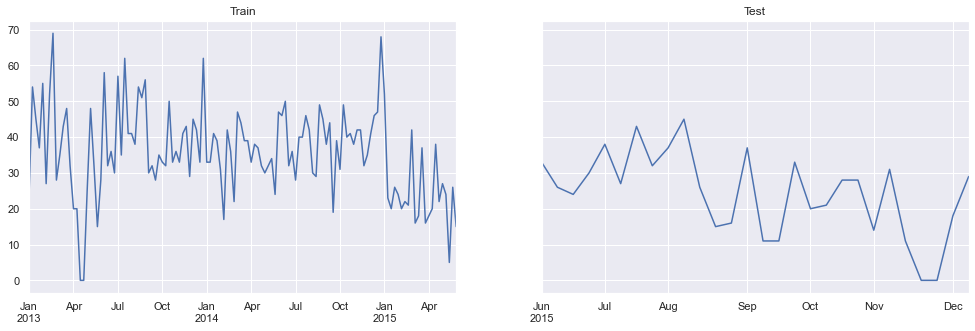

In [10]:
figsize=(15,5)
#SKU are low
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=figsize)
ts_train['sales'].plot(ax=ax[0], grid=True, title="Train")
ts_test['sales'].plot(ax=ax[1], grid=True, title="Test")
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)
plt.show()

In [11]:
#change the train size and viualize the learning curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

def split_data(train_data,test_data):
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])

    train_data['month'] = train_data['date'].dt.month
    train_data['day'] = train_data['date'].dt.dayofweek
    train_data['year'] = train_data['date'].dt.year

    test_data['month'] = test_data['date'].dt.month
    test_data['day'] = test_data['date'].dt.dayofweek
    test_data['year'] = test_data['date'].dt.year

    col = [i for i in test_data.columns if i not in ['date','shop_id']]
    y = 'sales'
    X = train_data.values
    splits = TimeSeriesSplit(n_splits=3)
    splits.split(X)
    train_x, test_x, train_y, test_y = train_test_split(train_data[col],train_data[y], train_size=0.8, random_state=2018)
    return (train_x, test_x, train_y, test_y,col)

train_x, test_x, train_y, test_y,col = split_data(train_data = ts_train.astype({"sales": int, "item_cnt_day": int}),
                                                  test_data = ts_test.astype({"sales": int, "item_cnt_day": int}))
train_x.shape,train_y.shape,test_x.shape

((100, 5), (100,), (26, 5))

In [12]:
from matplotlib import pyplot
X = ts_train.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))

Observations: 64
Training Observations: 33
Testing Observations: 31
Observations: 95
Training Observations: 64
Testing Observations: 31
Observations: 126
Training Observations: 95
Testing Observations: 31


<Figure size 432x288 with 0 Axes>

## Model validation and test

In [13]:
def model(train_x,train_y,test_x,test_y,col):
    params = {
         'max_depth': 10,
         'task': 'train',
         'boosting_type': 'gbdt',
         'objective': 'regression_l1',
         'metric': 'mape',
         'num_leaves': 64,
         'learning_rate': 0.2,
         'feature_fraction': 0.9,
         'bagging_fraction': 0.8,
         'bagging_freq': 5,
         'lambda_l1': 3.097758978478437,
         'lambda_l2': 2.9482537987198496,
         'verbose': 5,
         'min_child_weight': 6.996211413900573,
         'min_split_gain': 0.037310344962162616,
        }
    
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(test_x,test_y)
    model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=5)
    #make the prediction on the test set
    y_test = model.predict(test_x[col])
    return y_test,model

In [15]:
#train_x[['sales','month', 'day', 'year']]
y_test, model = model(train_x,train_y,test_x,test_y,col)
result = pd.DataFrame(y_test)
result.index = final_df.index[2:]
final_df['forecast_lgbm'] = result

[1]	training's mape: 1.0056	valid_1's mape: 0.27745
Training until validation scores don't improve for 5 rounds
[2]	training's mape: 0.937865	valid_1's mape: 0.234581
[3]	training's mape: 0.90243	valid_1's mape: 0.213031
[4]	training's mape: 0.841114	valid_1's mape: 0.178035
[5]	training's mape: 0.78673	valid_1's mape: 0.149565
[6]	training's mape: 0.74717	valid_1's mape: 0.126347
[7]	training's mape: 0.715428	valid_1's mape: 0.108214
[8]	training's mape: 0.709056	valid_1's mape: 0.106285
[9]	training's mape: 0.705046	valid_1's mape: 0.102773
[10]	training's mape: 0.699779	valid_1's mape: 0.101924
[11]	training's mape: 0.655979	valid_1's mape: 0.0923996
[12]	training's mape: 0.6204	valid_1's mape: 0.0856681
[13]	training's mape: 0.593984	valid_1's mape: 0.0841663
[14]	training's mape: 0.574171	valid_1's mape: 0.0844943
[15]	training's mape: 0.573712	valid_1's mape: 0.0833661
[16]	training's mape: 0.571953	valid_1's mape: 0.0821221
[17]	training's mape: 0.572334	valid_1's mape: 0.081715

In [114]:
#y_test = pd.DataFrame(y_test)
#y_test['_pred'] = y_test.shift(1)
#y_test
#y_test
final_df.shape

(28, 5)

In [17]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(np.ma.masked_equal(y_true,0)), np.array(np.ma.masked_equal(y_pred,0))
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

<AxesSubplot:xlabel='date'>

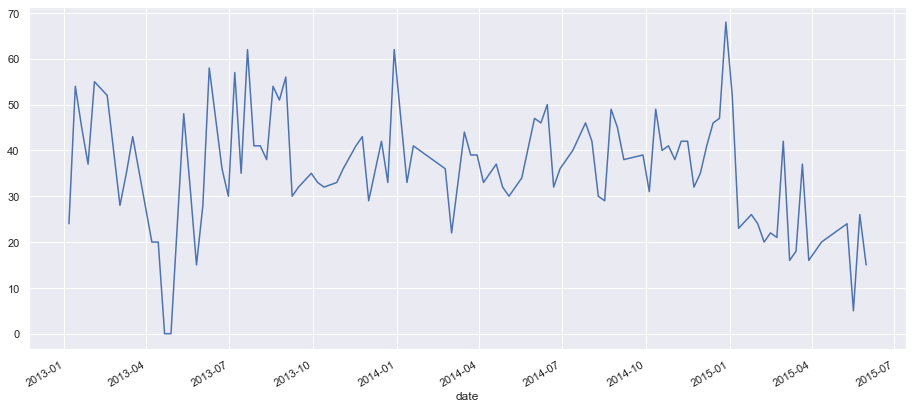

In [18]:
train_x['date'] = train_x.index
naive_df = pd.DataFrame(train_x[['date', 'sales']])
ax = naive_df['sales'].plot(label='observed')
naive_df['forecast'] = naive_df['sales'].shift(1)
naive_df['forecast'][100:].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

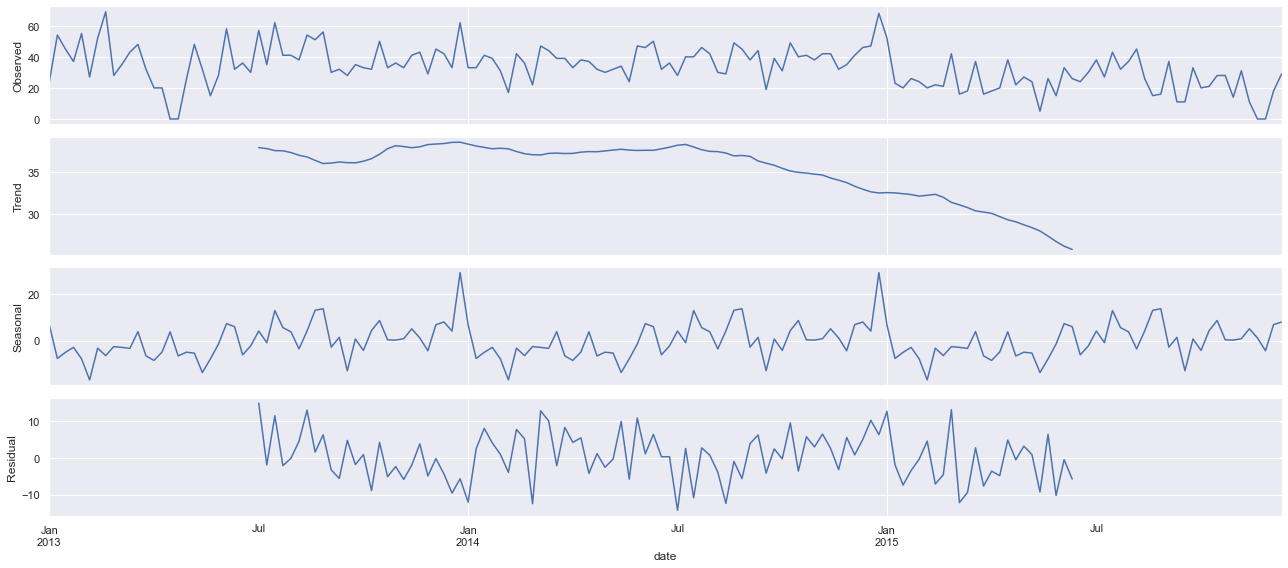

In [105]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
#Y is the data used for the forecast
y_1 = ts['item_cnt_day'].copy()
y_1 = y_1.rename('sales')
y_1 = y_1.resample('W').sum()
y = pd.DataFrame(train_x['sales'])
y = y['sales'].resample('W').sum()
decomposition = sm.tsa.seasonal_decompose(y_1, model='additive')
fig = decomposition.plot()
plt.show()

### Hyper paramenters Tuning for SARIMAX
in this case we try several hyperparameters in the range of integer (0,3) ths techniques is called Grid-Search and we select the best performing one based on the AIC criteria, after several tentavive and to also reduce the log rows i decided to print only the paramenters that have a AIC lower than 700


In [ ]:
%%time
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            if results.aic < 600:
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 0, 4, 12)
ARIMA(0, 0, 0)x(2, 3, 0, 12)12 - AIC:674.7079942281247
ARIMA(0, 0, 0)x(2, 3, 1, 12)12 - AIC:670.0284735446604
ARIMA(0, 0, 0)x(2, 4, 0, 12)12 - AIC:593.7915084042033
ARIMA(0, 0, 0)x(2, 4, 1, 12)12 - AIC:588.9008568288964
ARIMA(0, 0, 0)x(2, 4, 2, 12)12 - AIC:584.4657021444671
ARIMA(0, 0, 0)x(3, 1, 2, 12)12 - AIC:699.5542668687251
ARIMA(0, 0, 0)x(3, 2, 0, 12)12 - AIC:614.1033973232057
ARIMA(0, 0, 0)x(3, 2, 1, 12)12 - AIC:613.8867900821924
ARIMA(0, 0, 0)x(3, 2, 2, 12)12 - AIC:612.3189755523653
ARIMA(0, 0, 0)x(3, 3, 0, 12)12 - AIC:526.1946694244833
ARIMA(0, 0, 0)x(3, 3, 1, 12)12 - AIC:526.3709845796444
ARIMA(0, 0, 0)x(3, 4, 0, 12)12 - AIC:452.86726838586935
ARIMA(0, 0, 0)x(3, 4, 1, 12)12 - AIC:451.1574460032352
ARIMA(0, 0, 0)x(3, 4, 2, 12)12 - AIC:441.96099700614025
ARIMA(0, 0, 0)x(4, 0, 0, 12)12 

ARIMA(0, 0, 4)x(4, 2, 0, 12)12 - AIC:505.52437831354524
ARIMA(0, 0, 4)x(4, 2, 1, 12)12 - AIC:503.58406458408695
ARIMA(0, 0, 4)x(4, 2, 2, 12)12 - AIC:505.23928841071057
ARIMA(0, 0, 4)x(4, 3, 0, 12)12 - AIC:415.62086208501745
ARIMA(0, 0, 4)x(4, 3, 1, 12)12 - AIC:411.5670059898803
ARIMA(0, 0, 4)x(4, 4, 0, 12)12 - AIC:416.8793298385289
ARIMA(0, 0, 4)x(4, 4, 1, 12)12 - AIC:397.3321084672521
ARIMA(0, 0, 4)x(4, 4, 2, 12)12 - AIC:415.62113900078083
ARIMA(0, 1, 0)x(2, 3, 0, 12)12 - AIC:689.4392429161329
ARIMA(0, 1, 0)x(2, 3, 1, 12)12 - AIC:685.112655769391
ARIMA(0, 1, 0)x(2, 4, 0, 12)12 - AIC:614.3600004297195
ARIMA(0, 1, 0)x(2, 4, 1, 12)12 - AIC:599.6257929135411
ARIMA(0, 1, 0)x(3, 2, 0, 12)12 - AIC:624.7505808512809
ARIMA(0, 1, 0)x(3, 2, 1, 12)12 - AIC:625.629246257058
ARIMA(0, 1, 0)x(3, 2, 2, 12)12 - AIC:626.7022923936258
ARIMA(0, 1, 0)x(3, 3, 0, 12)12 - AIC:529.2422575641443
ARIMA(0, 1, 0)x(3, 3, 1, 12)12 - AIC:531.1741933284814
ARIMA(0, 1, 0)x(3, 4, 0, 12)12 - AIC:459.3702798514792
ARIMA(0

## Model validation

The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

In [106]:
#y --> split, y_1 all the dataset
mod = sm.tsa.statespace.SARIMAX(y_1,
                                order=(0, 1, 1),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              sales   No. Observations:                  154
Model:             SARIMAX(0, 1, 1)x(1, 2, 2, 12)   Log Likelihood                -420.838
Date:                            Sun, 21 Mar 2021   AIC                            851.675
Time:                                    20:53:42   BIC                            864.849
Sample:                                01-06-2013   HQIC                           857.011
                                     - 12-13-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8833      0.049    -17.866      0.000      -0.980      -0.786
ar.S.L12      -0.0041      0.002   

In [113]:
pred = results.get_prediction(start=pd.to_datetime('2015-06-07'), dynamic=False)
predictions = mod.fit().predict()
pred = results.get_prediction(start=pd.to_datetime('2015-06-07'), dynamic=False)
pred_ci = pred.conf_int()
y_forecasted = pred.predicted_mean
y_forecasted

date
2015-06-07    14.346722
2015-06-14    32.403846
2015-06-21    25.037824
2015-06-28    11.967728
2015-07-05    10.129327
2015-07-12    25.731891
2015-07-19    17.915835
2015-07-26    27.400272
2015-08-02    24.180991
2015-08-09    19.386112
2015-08-16    36.856489
2015-08-23    21.658324
2015-08-30    27.927401
2015-09-06    32.016991
2015-09-13    29.637973
2015-09-20    22.176605
2015-09-27    21.074721
2015-10-04    25.302219
2015-10-11    28.636503
2015-10-18    25.811194
2015-10-25    26.223400
2015-11-01    27.551501
2015-11-08    24.117727
2015-11-15    11.678106
2015-11-22    14.871551
2015-11-29    26.576146
2015-12-06    10.423787
2015-12-13     7.595520
Freq: W-SUN, dtype: float64

In [115]:
final_df['forecast_arima'] = y_forecasted

In [120]:
final_df = final_df.dropna(axis=0, how='any')

In [128]:
from sklearn.metrics import mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(np.ma.masked_equal(y_true,0)), np.array(np.ma.masked_equal(y_pred,0))
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [133]:
expected = final_df['sales']
forecast_arima = final_df['forecast_arima']
forecast_lgbm = final_df['forecast_lgbm']
forecast_naive = final_df['forecast_naive']
mae = mean_absolute_error(expected, forecast)
mae_lgbm = mean_absolute_error(expected, forecast_lgbm)
mae_naive = mean_absolute_error(expected, forecast_naive)

In [136]:
print('Examples of parameter combinations for Seasonal Actual, SARIMA, LGBM, NAIVE...')
print(mae, mae_lgbm, mae_naive)

Examples of parameter combinations for Seasonal Actual, SARIMA, LGBM, NAIVE...
11.57442872706511 14.747864207062086 10.73076923076923


<AxesSubplot:xlabel='date'>

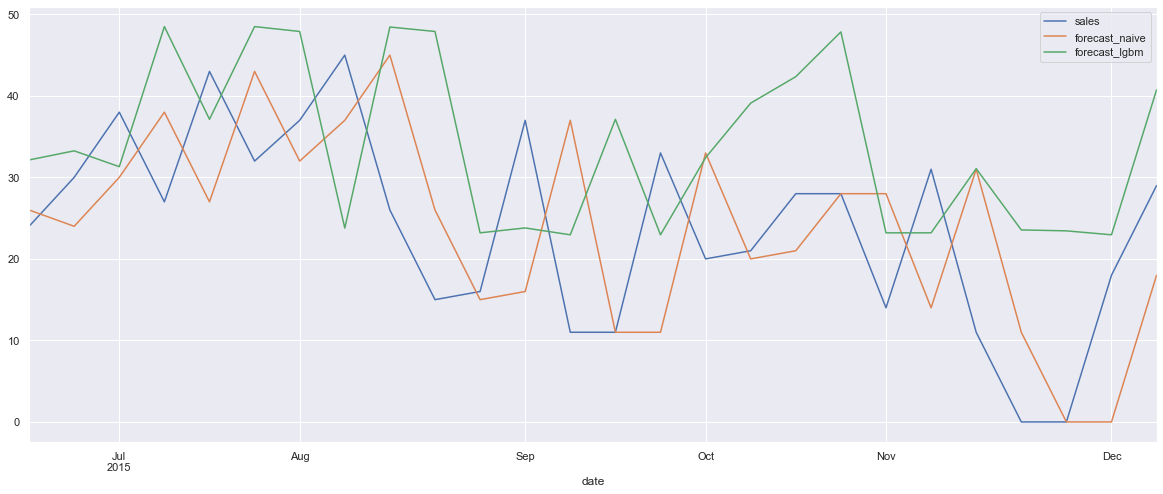

In [144]:
final_df[['sales', 'forecast_naive', 'forecast_lgbm']].plot()

In [ ]:
final_df[['sales', 'forecast_naive', 'forecast_arima']].plot()